In [38]:
#Using Cryptocompare Free API which has historical data for over 90 exchanges, 1800 coins/tokens - 
#CCCAGG is the weighted average price of all exchanges tracked 
#More information - (https://www.cryptocompare.com/coins/guides/how-does-our-cryptocurrecy-index-work/)
#2000 limit of rows

from_symbol = 'BTC'
to_symbol = 'USD'

exchange = 'CCCAGG'
#Intervals supported minute, hour and day
datetime_interval = 'day'

In [445]:
import pandas as pd
import requests
from datetime import datetime

In [446]:
#Functions to automate naming and saving of csv files from API

def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    #Use aggregate to group different periods of time
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)


Filtering 0 empty datapoints
Saving data to BTC_USD_CCCAGG_day_2018-03-21.csv


In [447]:
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)


Reading data from BTC_USD_CCCAGG_day_2018-03-21.csv
(2001, 6)


In [448]:
df.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2012-09-29,12.21,12.49,12.39,12.36,17061.66,211507.34
2012-09-30,12.30,12.45,12.36,12.40,7793.91,96462.09
2012-10-01,12.32,12.48,12.40,12.40,24826.69,307618.78
2012-10-02,12.34,12.88,12.40,12.84,50833.35,642027.91
2012-10-03,12.68,12.99,12.84,12.89,32955.07,422995.61


In [449]:
df.tail()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2018-03-18,7318.46,8299.86,7882.67,8215.40,198796.34,1.535519e+09
2018-03-19,8129.66,8725.60,8215.50,8623.14,171829.52,1.447813e+09
2018-03-20,8339.80,9056.23,8623.14,8920.71,131959.66,1.150462e+09
2018-03-21,8778.69,9184.51,8920.53,8906.63,108469.54,9.778071e+08
2018-03-22,8906.63,8912.65,8906.63,8912.65,0.00,0.000000e+00


In [426]:
df.describe()

,low,high,open,close,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,1371.188761,1498.917346,1439.635857,1444.082759,60765.688141,1.637316e+08
std,2770.584168,3091.110202,2950.983210,2955.516905,59786.283902,4.768647e+08
min,9.740000,10.650000,10.170000,10.170000,404.380000,9.646209e+04
25%,229.930000,238.660000,234.300000,234.660000,21365.640000,3.688565e+06
50%,428.520000,450.100000,438.210000,438.650000,44153.620000,1.501556e+07
75%,808.630000,900.920000,845.020000,856.910000,81867.300000,4.546160e+07
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09


In [427]:
import talib as ta
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')

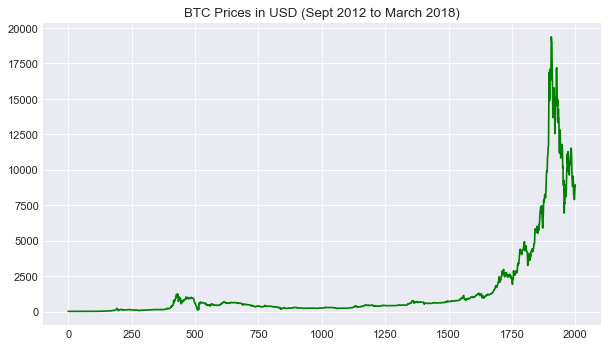

In [428]:
plt.plot(df.close, color='g')
plt.title('BTC Prices in USD (Sept 2012 to March 2018)')
plt.show()

In [450]:
#Shift price 1 index lag behind 
df['predictprice'] = df['close'].shift(-1)

#Using technical analysis library to create common technical indicators

#Common Technical Analysis Indicators
df['SMA'] = ta.SMA(df.close)
df['AD'] = ta.AD(df.high,df.low,df.close,df.volumefrom)
df['ADOSC'] = ta.ADOSC(df.high,df.low,df.close,df.volumefrom)
df['ADX'] = ta.ADX(df.high,df.low,df.close)
df['ADXR'] = ta.ADXR(df.high,df.low,df.close)
df['APO'] = ta.APO(df.close)
df['AROONOSC'] = ta.AROONOSC(df.high,df.low)
df['ATR'] = ta.ATR(df.high,df.low,df.close)
df['BOP'] = ta.BOP(df.open,df.high,df.low,df.close)
df['CCI'] = ta.CCI(df.high,df.low,df.close)
df['CMO'] = ta.CMO(df.close)
df['DEMA'] = ta.DEMA(df.close)
df['DX'] = ta.DX(df.high,df.low,df.close)
df['EMA'] = ta.EMA(df.close)
df['HT_TRENDMODE'] = ta.HT_TRENDMODE(df.close)
df['HT_TRENDLINE'] = ta.HT_TRENDLINE(df.close)
df['KAMA'] = ta.KAMA(df.close)
df['MA'] = ta.MA(df.close)
df['MFI'] = ta.MFI(df.high,df.low,df.close,df.volumefrom)
df['MINUS_DI'] = ta.MINUS_DI(df.high,df.low,df.close)
df['MINUS_DM'] = ta.MINUS_DM(df.high,df.low)
df['MOM'] = ta.MOM(df.close)
df['OBV'] = ta.OBV(df.close,df.volumefrom)
df['PLUS_DI'] = ta.PLUS_DI(df.high,df.low,df.close)
df['PLUS_DM'] = ta.PLUS_DM(df.high,df.low)
df['PPO'] = ta.PPO(df.close)
df['ROCP'] = ta.ROCP(df.close)
df['RSI'] = ta.RSI(df.close)
df['SAR'] = ta.SAR(df.high,df.low)
df['SAREXT'] = ta.SAREXT(df.high,df.low)
df['SMA'] = ta.SMA(df.close)
df['T3'] = ta.T3(df.close)
df['TEMA'] = ta.TEMA(df.close)
df['TRANGE'] = ta.TRANGE(df.high,df.low,df.close)
df['TRIX'] = ta.TRIX(df.close)
df['ULTOSC'] = ta.ULTOSC(df.high,df.low,df.close)
df['WILLR'] = ta.WILLR(df.high,df.low,df.close)
df['WMA'] = ta.WMA(df.close)

#Candlestick indicators
df['CDL2CROWS'] = ta.CDL2CROWS(df.open,df.high,df.low,df.close)
df['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(df.open,df.high,df.low,df.close)
df['CDL3INSIDE'] = ta.CDL3INSIDE(df.open,df.high,df.low,df.close)
df['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(df.open,df.high,df.low,df.close)
df['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(df.open,df.high,df.low,df.close)
df['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(df.open,df.high,df.low,df.close)
df['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(df.open,df.high,df.low,df.close)
df['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(df.open,df.high,df.low,df.close)
df['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(df.open,df.high,df.low,df.close)
df['CDLBELTHOLD'] = ta.CDLBELTHOLD(df.open,df.high,df.low,df.close)
df['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(df.open,df.high,df.low,df.close)
df['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(df.open,df.high,df.low,df.close)
df['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(df.open,df.high,df.low,df.close)
df['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(df.open,df.high,df.low,df.close)
df['CDLDOJI'] = ta.CDLDOJI(df.open,df.high,df.low,df.close)
df['CDLDOJISTAR'] = ta.CDLDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(df.open,df.high,df.low,df.close)
df['CDLENGULFING'] = ta.CDLENGULFING(df.open,df.high,df.low,df.close)
df['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(df.open,df.high,df.low,df.close)
df['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(df.open,df.high,df.low,df.close)
df['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(df.open,df.high,df.low,df.close)
df['CDLHAMMER'] = ta.CDLHAMMER(df.open,df.high,df.low,df.close)
df['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(df.open,df.high,df.low,df.close)
df['CDLHARAMI'] = ta.CDLHARAMI(df.open,df.high,df.low,df.close)
df['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(df.open,df.high,df.low,df.close)
df['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKE'] = ta.CDLHIKKAKE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(df.open,df.high,df.low,df.close)
df['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(df.open,df.high,df.low,df.close)
df['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(df.open,df.high,df.low,df.close)
df['CDLINNECK'] = ta.CDLINNECK(df.open,df.high,df.low,df.close)
df['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(df.open,df.high,df.low,df.close)
df['CDLKICKING'] = ta.CDLKICKING(df.open,df.high,df.low,df.close)
df['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(df.open,df.high,df.low,df.close)
df['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(df.open,df.high,df.low,df.close)
df['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(df.open,df.high,df.low,df.close)
df['CDLLONGLINE'] = ta.CDLLONGLINE(df.open,df.high,df.low,df.close)
df['CDLMARUBOZU'] = ta.CDLMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(df.open,df.high,df.low,df.close)
df['CDLMATHOLD'] = ta.CDLMATHOLD(df.open,df.high,df.low,df.close)
df['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(df.open,df.high,df.low,df.close)
df['CDLONNECK'] = ta.CDLONNECK(df.open,df.high,df.low,df.close)
df['CDLPIERCING'] = ta.CDLPIERCING(df.open,df.high,df.low,df.close)
df['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(df.open,df.high,df.low,df.close)
df['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(df.open,df.high,df.low,df.close)
df['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(df.open,df.high,df.low,df.close)
df['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(df.open,df.high,df.low,df.close)
df['CDLSHORTLINE'] = ta.CDLSHORTLINE(df.open,df.high,df.low,df.close)
df['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(df.open,df.high,df.low,df.close)
df['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(df.open,df.high,df.low,df.close)
df['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(df.open,df.high,df.low,df.close)
df['CDLTAKURI'] = ta.CDLTAKURI(df.open,df.high,df.low,df.close)
df['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(df.open,df.high,df.low,df.close)
df['CDLTHRUSTING'] = ta.CDLTHRUSTING(df.open,df.high,df.low,df.close)
df['CDLTRISTAR'] = ta.CDLTRISTAR(df.open,df.high,df.low,df.close)
df['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(df.open,df.high,df.low,df.close)
df['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(df.open,df.high,df.low,df.close)
df['CDLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(df.open,df.high,df.low,df.close)


In [451]:
df.tail(30)

,low,high,open,close,volumefrom,volumeto,predictprice,SMA,AD,ADOSC,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-21,10256.21,11295.58,11256.78,10481.66,183274.25,1.982721e+09,9847.96,9741.968667,1.623105e+07,57254.155557,...,0,0,0,0,0,0,0,0,0,0
2018-02-22,9757.19,10941.57,10481.66,9847.96,175506.26,1.795952e+09,10175.51,9708.293000,1.608244e+07,-20295.019010,...,0,0,0,0,0,0,0,0,0,0
2018-02-23,9604.00,10420.67,9847.96,10175.51,139373.76,1.399448e+09,9705.73,9666.509333,1.613814e+07,-32453.468854,...,0,0,0,0,0,0,0,0,0,0
2018-02-24,9396.54,10528.00,10175.51,9705.73,125269.68,1.244484e+09,9610.11,9617.504667,1.608133e+07,-52551.602927,...,0,0,0,0,0,0,0,0,0,0
2018-02-25,9329.44,9873.79,9705.73,9610.11,82430.45,7.930932e+08,10326.50,9567.701667,1.608390e+07,-55177.536277,...,-100,0,0,0,0,0,0,0,0,0
2018-02-26,9411.82,10457.51,9610.11,10326.50,117416.47,1.181729e+09,10594.76,9529.928000,1.617190e+07,-23237.149767,...,0,0,0,0,0,0,0,0,0,0
2018-02-27,10154.24,10879.38,10326.50,10594.76,99772.39,1.060841e+09,10334.44,9490.828667,1.619335e+07,-1233.044626,...,0,0,0,0,0,0,0,0,0,0
2018-02-28,10303.14,11067.76,10594.76,10334.44,105434.79,1.126075e+09,10929.37,9460.845000,1.609655e+07,-22920.150516,...,0,0,0,0,0,0,0,0,0,0
2018-03-01,10247.56,11090.30,10334.44,10929.37,88432.44,9.524721e+08,11043.12,9488.248667,1.615120e+07,-12317.238577,...,0,0,0,0,0,0,0,0,0,0


In [452]:
df = df.loc[:, (df != 0).any(axis=0)]
df.describe()

,low,high,open,close,volumefrom,volumeto,predictprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,2000.000000,1972.000000,2.001000e+03,1992.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,1375.633793,1503.365222,1444.080795,1448.531499,60754.451494,1.637501e+08,1449.249585,1401.999970,6.035951e+06,28417.681492,...,18.240880,5.947026,1.149425,2.198901,15.192404,0.499750,2.148926,-0.349825,-0.299850,1.799100
std,2775.533240,3095.370642,2955.527281,2960.057046,59798.460413,4.768959e+08,2960.623000,2856.516026,3.917936e+06,47992.393615,...,38.627761,40.368493,16.842748,14.668416,35.903697,9.987498,48.583740,52.486928,5.469008,13.295173
min,9.740000,10.650000,10.170000,10.170000,0.000000,0.000000e+00,10.170000,11.030667,-6.105166e+03,-148951.794029,...,0.000000,-100.000000,-100.000000,0.000000,0.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000
25%,230.210000,238.780000,234.660000,234.730000,21354.150000,3.688565e+06,234.955000,236.299417,3.823340e+06,-2078.291511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,428.600000,450.190000,438.650000,439.620000,44153.620000,1.501556e+07,439.840000,448.219000,4.063121e+06,16389.515624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,810.470000,901.490000,856.910000,860.150000,81867.300000,4.546160e+07,863.120000,837.304500,7.963228e+06,54723.190716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09,19345.490000,15737.841333,1.642401e+07,291297.349657,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,100.000000


In [453]:
#Delete rows with NAN
df2 = df.dropna()
df2

#Delete columns with all 0s
df2 = df2.loc[:, (df != 0).any(axis=0)]
df2


,low,high,open,close,volumefrom,volumeto,predictprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
datetime,,,,,,,,,,,,,,,,,,,,,
2012-12-26,13.20,13.47,13.35,13.47,15840.13,2.113491e+05,13.42,13.218000,5.947474e+05,24447.589832,...,0,0,0,0,0,0,0,0,0,0
2012-12-27,13.25,13.47,13.47,13.42,19822.05,2.653118e+05,13.42,13.258667,6.055594e+05,26803.361291,...,0,0,0,0,0,0,0,0,0,0
2012-12-28,13.34,13.65,13.42,13.42,23813.01,3.202234e+05,13.40,13.294333,5.940370e+05,21664.190891,...,100,0,0,0,0,0,0,100,0,0
2012-12-29,13.27,13.67,13.42,13.40,26149.14,3.527223e+05,13.45,13.326000,5.848848e+05,14680.267783,...,100,0,0,0,100,0,0,-100,0,0
2012-12-30,13.35,13.59,13.40,13.45,11764.20,1.582772e+05,13.51,13.355333,5.829241e+05,9864.779440,...,0,0,0,0,0,0,0,100,0,0
2012-12-31,13.37,13.56,13.45,13.51,15049.79,2.027989e+05,13.30,13.387000,5.900529e+05,9266.278590,...,0,100,0,0,0,0,0,0,0,0
2013-01-01,13.16,13.56,13.51,13.30,28406.21,3.788793e+05,13.28,13.413667,5.815311e+05,5467.546507,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,13.16,13.40,13.30,13.28,17966.81,2.391562e+05,13.40,13.433667,5.815311e+05,3416.470063,...,100,0,0,0,100,0,0,-100,0,0
2013-01-03,13.25,13.46,13.28,13.40,18032.25,2.408459e+05,13.50,13.433333,5.892592e+05,4725.748330,...,0,100,0,0,0,0,0,0,0,0


In [454]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
import numpy as np


X = df.drop(df[['low','high','open','close','volumefrom','volumeto','predictprice']], axis = 1)
#Drop out NAN
X = X.dropna()
#Drop last row as we do not have future information
X = X[:-1]


In [455]:
# This creates a LinearRegression object
lm = LinearRegression()
X
lm.fit(X,df2.predictprice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [456]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]


,features,estimatedCoefficients
0,SMA,-0.020719
1,AD,0.000029
2,ADOSC,0.000082
3,ADX,-0.512882
4,ADXR,0.441918
5,APO,0.507962
6,AROONOSC,-0.023802
7,ATR,1.614216
8,BOP,8.066759
9,CCI,-0.105625


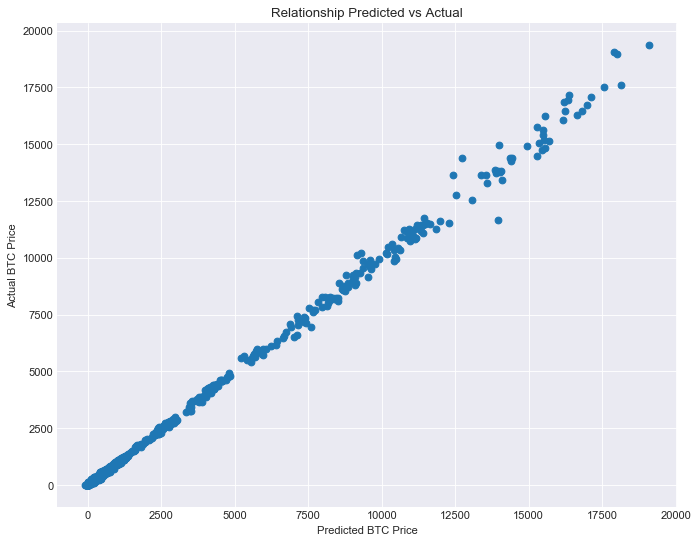

In [457]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(lm.predict(X), df2.close)
plt.xlabel("Predicted BTC Price")
plt.ylabel("Actual BTC Price")
plt.title("Relationship Predicted vs Actual")
plt.show()

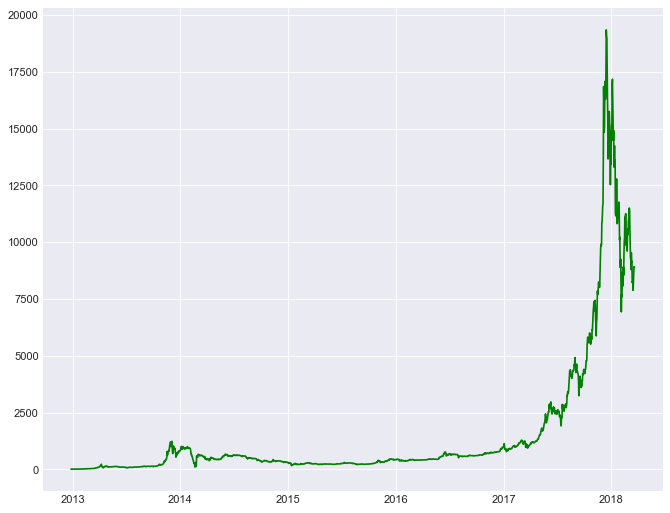

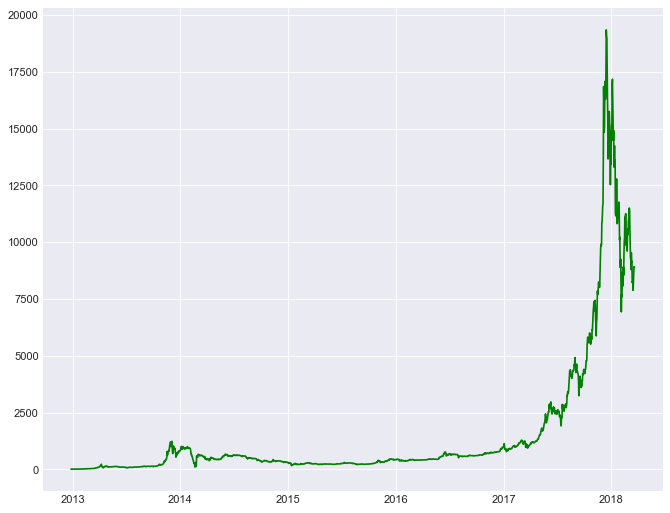

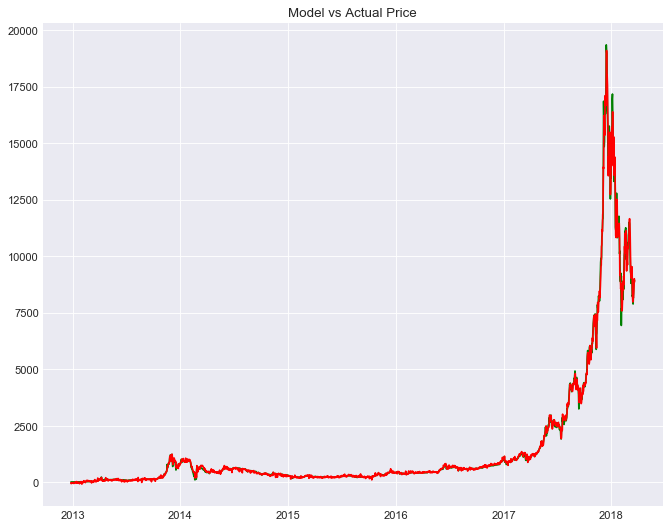

R-Squared score: 0.998


In [460]:
#Line Graph
df3 = df2
df3['predictedmodel LM'] = lm.predict(X)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(df3.predictprice, color='g')
plt.plot(df3['predictedmodel LM'], color='r')
plt.title("Model vs Actual Price")
plt.show()
print('R-Squared score: {:.3f}'.format(lm.score(X,df2.close)))


In [462]:
df3[['predictprice','predictedmodel LM']]

,predictprice,predictedmodel LM
datetime,,
2012-12-26,13.42,-31.468353
2012-12-27,13.42,-59.838968
2012-12-28,13.40,-20.859711
2012-12-29,13.45,-36.682195
2012-12-30,13.51,-41.965357
2012-12-31,13.30,-14.732679
2013-01-01,13.28,-39.498808
2013-01-02,13.40,-35.474607
2013-01-03,13.50,-29.029575


In [463]:
#Ridge regression

from sklearn.linear_model import Ridge
#Alpha is the parameter penalty - regulariztion - higher # higher penalty which will reduce complexity
linridge = Ridge(alpha=20).fit(X,df2.predictprice)
#Feature normalization so alpha penalty is applied equaly for all feature variables

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff: {}'.format(linridge.coef_))
print('R-squared score: {:.3f}'.format(linridge.score(X,df2.predictprice)))
print('Number of non-zero features {:.3f}'.format(np.sum(linridge.coef_ != 0)))


df3['Ridge'] = linridge.predict(X)


ridge regression linear model intercept: -172.39659043117877
ridge regression linear model coeff: [ -2.07067908e-02   2.91454385e-05   8.15473428e-05  -5.12524391e-01
   4.39510967e-01   5.08705691e-01  -2.51428553e-02   1.61514353e+00
   7.09956474e+00  -1.05582349e-01   1.11866865e+00   6.49820436e-01
   3.97746149e-01   4.80697438e-01   7.44337755e-01  -4.29290195e-01
  -4.68777419e-01  -2.07069475e-02   4.39871829e-01   2.37619495e+00
  -5.69801519e-01   4.00587804e-01  -2.54068668e-05  -2.42995301e+00
   3.05705630e-01   1.04244054e+00  -2.35479364e+00   5.59334323e-01
   3.50827192e-02   2.11129954e-02  -6.19218275e-01  -4.14912754e-01
   1.68001426e-01  -2.36015335e+00   4.07300467e-01   1.79607371e-01
   1.75188252e+00  -4.45706392e+00   7.61764906e+00   1.51942886e-01
   1.38698003e-01   2.67158059e-01  -1.54873684e-01   8.03209583e-01
  -1.87372409e+01   9.77671281e-02   5.35041503e+00  -9.04669002e-01
  -3.68924856e-02   3.28347851e-01  -2.39918387e+00   2.49627892e-01
  -1.

In [464]:
#Ridge Regression - normalizing features so alpha regularization applied uniformly
#MinMaxScaler is one of the most popular transform methods
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
linridge2 = Ridge(alpha=20).fit(X_scaled,df2.predictprice)
r2_score = linridge2.score(X_scaled,df2.predictprice)
print(r2_score)

df3['RidgeNormalized'] = linridge2.predict(X_scaled)


0.986381786171


In [465]:
#Kernel Ridge Regression Not Normalized
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

#scaler = MinMaxScaler()

#X_scaledK = scaler.fit_transform(X)
RidgeK = KernelRidge(alpha=20).fit(X,df2.predictprice)
#kr_r2_score = KernelRidge.score(X_scaledK,df2.predictprice)
#print(kr_r2_score)

df3['KernelRidge'] = RidgeK.predict(X)



C:\Users\peter\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.760986529966273e-18



In [466]:
#Kernel Ridge Regression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

scaler = MinMaxScaler()

X_scaledK = scaler.fit_transform(X)
RidgeK = KernelRidge(alpha=20).fit(X_scaledK,df2.predictprice)
#kr_r2_score = KernelRidge.score(X_scaledK,df2.predictprice)
#print(kr_r2_score)

df3['KernelRidgeNormalized'] = RidgeK.predict(X_scaledK)



In [467]:
df3[['predictprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KernelRidge']]

,predictprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KernelRidge
datetime,,,,,,
2012-12-26,13.42,-31.468353,-31.569052,-93.735320,-112.417707,-36.750
2012-12-27,13.42,-59.838968,-59.551894,-152.868127,84.366519,-58.125
2012-12-28,13.40,-20.859711,-20.829291,-107.912615,-106.612847,-23.125
2012-12-29,13.45,-36.682195,-36.710298,-186.061105,-138.154499,-33.750
2012-12-30,13.51,-41.965357,-42.101714,-152.300675,-118.968963,-43.125
2012-12-31,13.30,-14.732679,-14.659083,-147.937854,-116.325878,-10.500
2013-01-01,13.28,-39.498808,-39.056221,-191.414607,-152.606322,-37.125
2013-01-02,13.40,-35.474607,-35.463967,-199.995546,-137.794227,-33.750
2013-01-03,13.50,-29.029575,-29.144053,-122.165743,-66.349559,-27.250


In [468]:
#K Nearest Neighbor Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaledK = scaler.fit_transform(X)

knnreg = KNeighborsRegressor(n_neighbors=5).fit(X_scaledK,df2.predictprice)

print('R-squared test score: {}'.format(knnreg.score(X_scaledK,df2.predictprice)))

df3['KNeighbors'] = knnreg.predict(X_scaledK)


R-squared test score: 0.9832827917882764


In [469]:
#Tree Based Regressor
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

tree = DecisionTreeRegressor(max_depth=8).fit(X,df2.predictprice)

print('R-squared test score: {}'.format(tree.score(X,df2.predictprice)))

df3['Tree'] = tree.predict(X)


R-squared test score: 0.9997261366863753


In [470]:
lineplot = df3[['predictprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot

,predictprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree
datetime,,,,,,,
2012-12-26,13.42,-31.468353,-31.569052,-93.735320,-112.417707,136.212,16.335682
2012-12-27,13.42,-59.838968,-59.551894,-152.868127,84.366519,80.418,16.335682
2012-12-28,13.40,-20.859711,-20.829291,-107.912615,-106.612847,388.760,16.335682
2012-12-29,13.45,-36.682195,-36.710298,-186.061105,-138.154499,296.510,16.335682
2012-12-30,13.51,-41.965357,-42.101714,-152.300675,-118.968963,206.832,16.335682
2012-12-31,13.30,-14.732679,-14.659083,-147.937854,-116.325878,139.646,16.335682
2013-01-01,13.28,-39.498808,-39.056221,-191.414607,-152.606322,204.934,16.335682
2013-01-02,13.40,-35.474607,-35.463967,-199.995546,-137.794227,232.942,16.335682
2013-01-03,13.50,-29.029575,-29.144053,-122.165743,-66.349559,155.020,16.335682


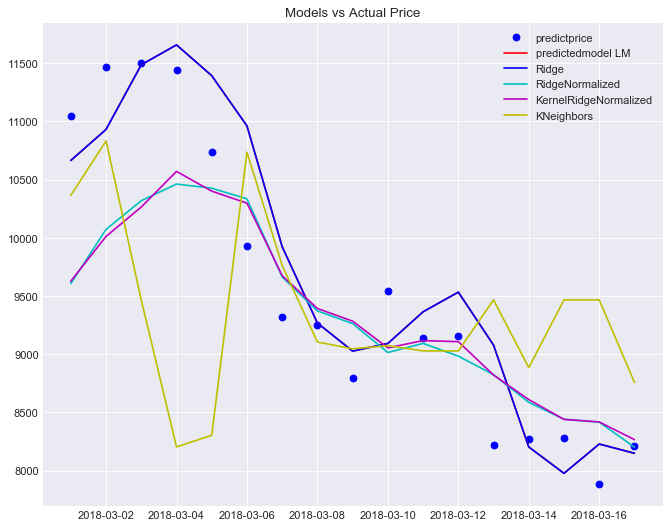

In [471]:
import matplotlib.pyplot as plt
import datetime
import math
from sklearn.metrics import mean_squared_error


fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
lineplot = df3[['predictprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot = lineplot.loc['2018-3-1':'2018-3-17']

plt.plot(lineplot.predictprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')

#plt.plot(lineplot.Tree, color='k')

plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()



In [472]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['KNeighbors']))

print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)


469.83092518366533
469.80266869271884
689.0775037036643
689.3614262992966
1300.2756161852312


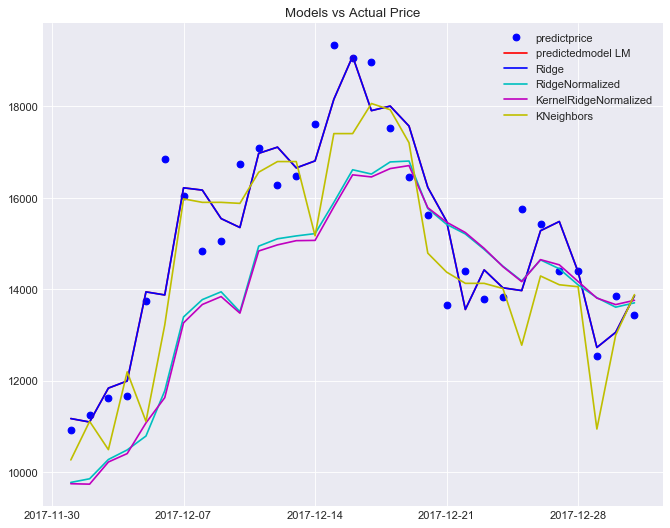

In [473]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

lineplot = df3[['predictprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot = lineplot.loc['2017-12-1':'2017-12-31']

plt.plot(lineplot.predictprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')


#plt.plot(lineplot.Tree, color='k')

plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()


In [474]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['predictprice'], lineplot['KNeighbors']))

print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)


958.4683586410831
958.4851140764366
1875.609321534854
1925.441747240566
1327.1794584886377
